<a href="https://colab.research.google.com/github/RifaldiAchmad/UAS-Deep-Learning/blob/main/UAS_Deep_Learning_Rifaldi_Achmad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/RifaldiAchmad/UAS-Deep-Learning.git

Cloning into 'UAS-Deep-Learning'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 437.82 KiB | 1.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import logging
import seaborn as sns
from tqdm import tqdm

In [3]:
# Set random seed for reproducibility
SEED = 1507
np.random.seed(SEED)
tf.random.set_seed(SEED)

# **Prepocessing dan Filtering Data**

In [4]:
# Memuat data
file_path = '/content/UAS-Deep-Learning/UAS Deep Learning.csv'
dataku = pd.read_csv(file_path)

# Mengambil kolom yang relevan
dataku = dataku[['created_at', 'entity', 'commentcount', 'likes', 'retweets', 'quotes', 'replies']]

# Memeriksa nilai NaN atau null pada data
dataku.head()

,created_at,entity,commentcount,likes,retweets,quotes,replies
0,2023-01-01 13:50:44,Lainnya,0.0,NaN,NaN,NaN,1
1,2023-01-01 11:00:01,Lainnya,31.0,1837302.0,159.0,24686.0,31
2,2023-01-02 9:41:59,Suzuki,0.0,140.0,72.0,1510.0,0
3,2023-01-03 7:19:49,Toyota,0.0,642.0,1.0,757.0,0
4,2023-01-03 2:29:01,BMW,1.0,154655.0,402.0,96590.0,1


In [5]:
# Memeriksa nilai NaN atau null pada data
print("\nJumlah nilai NaN atau null pada setiap kolom:")
print(dataku.isnull().sum())


Jumlah nilai NaN atau null pada setiap kolom:
created_at        0
entity            0
commentcount    245
likes           522
retweets        522
quotes          522
replies           0
dtype: int64


In [6]:
# Mengisi nilai NaN atau null dengan nilai 0
data = dataku.fillna(0)
data.head()

,created_at,entity,commentcount,likes,retweets,quotes,replies
0,2023-01-01 13:50:44,Lainnya,0.0,0.0,0.0,0.0,1
1,2023-01-01 11:00:01,Lainnya,31.0,1837302.0,159.0,24686.0,31
2,2023-01-02 9:41:59,Suzuki,0.0,140.0,72.0,1510.0,0
3,2023-01-03 7:19:49,Toyota,0.0,642.0,1.0,757.0,0
4,2023-01-03 2:29:01,BMW,1.0,154655.0,402.0,96590.0,1


In [7]:
# Filter data untuk tahun 2023 dan entity Toyota
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')
data_2023 = data[(data['created_at'].dt.year == 2023) & (data['entity'] == 'Toyota')]

# Set 'created_at' sebagai index
data_2023.set_index('created_at', inplace=True)

# Resample data ke frekuensi harian, menjumlahkan metrik keterlibatan
toyota_daily = data_2023.resample('D').sum()

# Menangani nilai missing dengan mengisi 0 (tidak ada keterlibatan)
toyota_daily.fillna(0, inplace=True)
toyota_daily

,entity,commentcount,likes,retweets,quotes,replies
created_at,,,,,,
2023-01-03,Toyota,0.0,642.0,1.0,757.0,0
2023-01-04,Toyota,2.0,182703.0,18842.0,50754.0,2
2023-01-05,ToyotaToyota,6.0,3849272.0,414.0,1573900.0,6
2023-01-06,0,0.0,0.0,0.0,0.0,0
2023-01-07,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...
2023-12-26,0,0.0,0.0,0.0,0.0,0
2023-12-27,Toyota,0.0,469879.0,107.0,537963.0,0
2023-12-28,Toyota,0.0,0.0,0.0,0.0,6


In [8]:
# Identifikasi kolom numerik
numeric_columns = toyota_daily.select_dtypes(include=[np.number]).columns

# Normalisasi data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(toyota_daily[numeric_columns])

# Mengonversi kembali ke DataFrame untuk kenyamanan
scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns, index=toyota_daily.index)
scaled_df

,commentcount,likes,retweets,quotes,replies
created_at,,,,,
2023-01-03,0.000000,0.000014,0.000051,0.000077,0.000000
2023-01-04,0.002103,0.003857,0.959955,0.005193,0.000509
2023-01-05,0.006309,0.081256,0.021092,0.161028,0.001526
2023-01-06,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-07,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2023-12-26,0.000000,0.000000,0.000000,0.000000,0.000000
2023-12-27,0.000000,0.009919,0.005451,0.055040,0.000000
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.001526


# **Exploratory Data Analysis**

<ipython-input-9-429d10caa4ca>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entity_distribution.index, y=entity_distribution.values, palette='viridis')


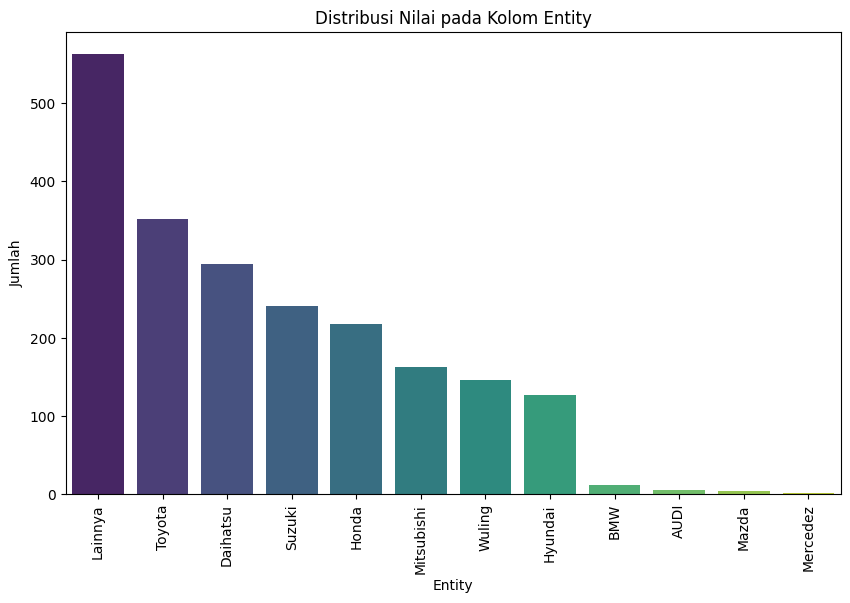

In [9]:
# Melihat distribusi nilai pada kolom 'entity'
entity_distribution = dataku['entity'].value_counts()

# Plot visualisasi distribusi
plt.figure(figsize=(10, 6))
sns.barplot(x=entity_distribution.index, y=entity_distribution.values, palette='viridis')
plt.title('Distribusi Nilai pada Kolom Entity')
plt.xlabel('Entity')
plt.ylabel('Jumlah')
plt.xticks(rotation=90)
plt.show()

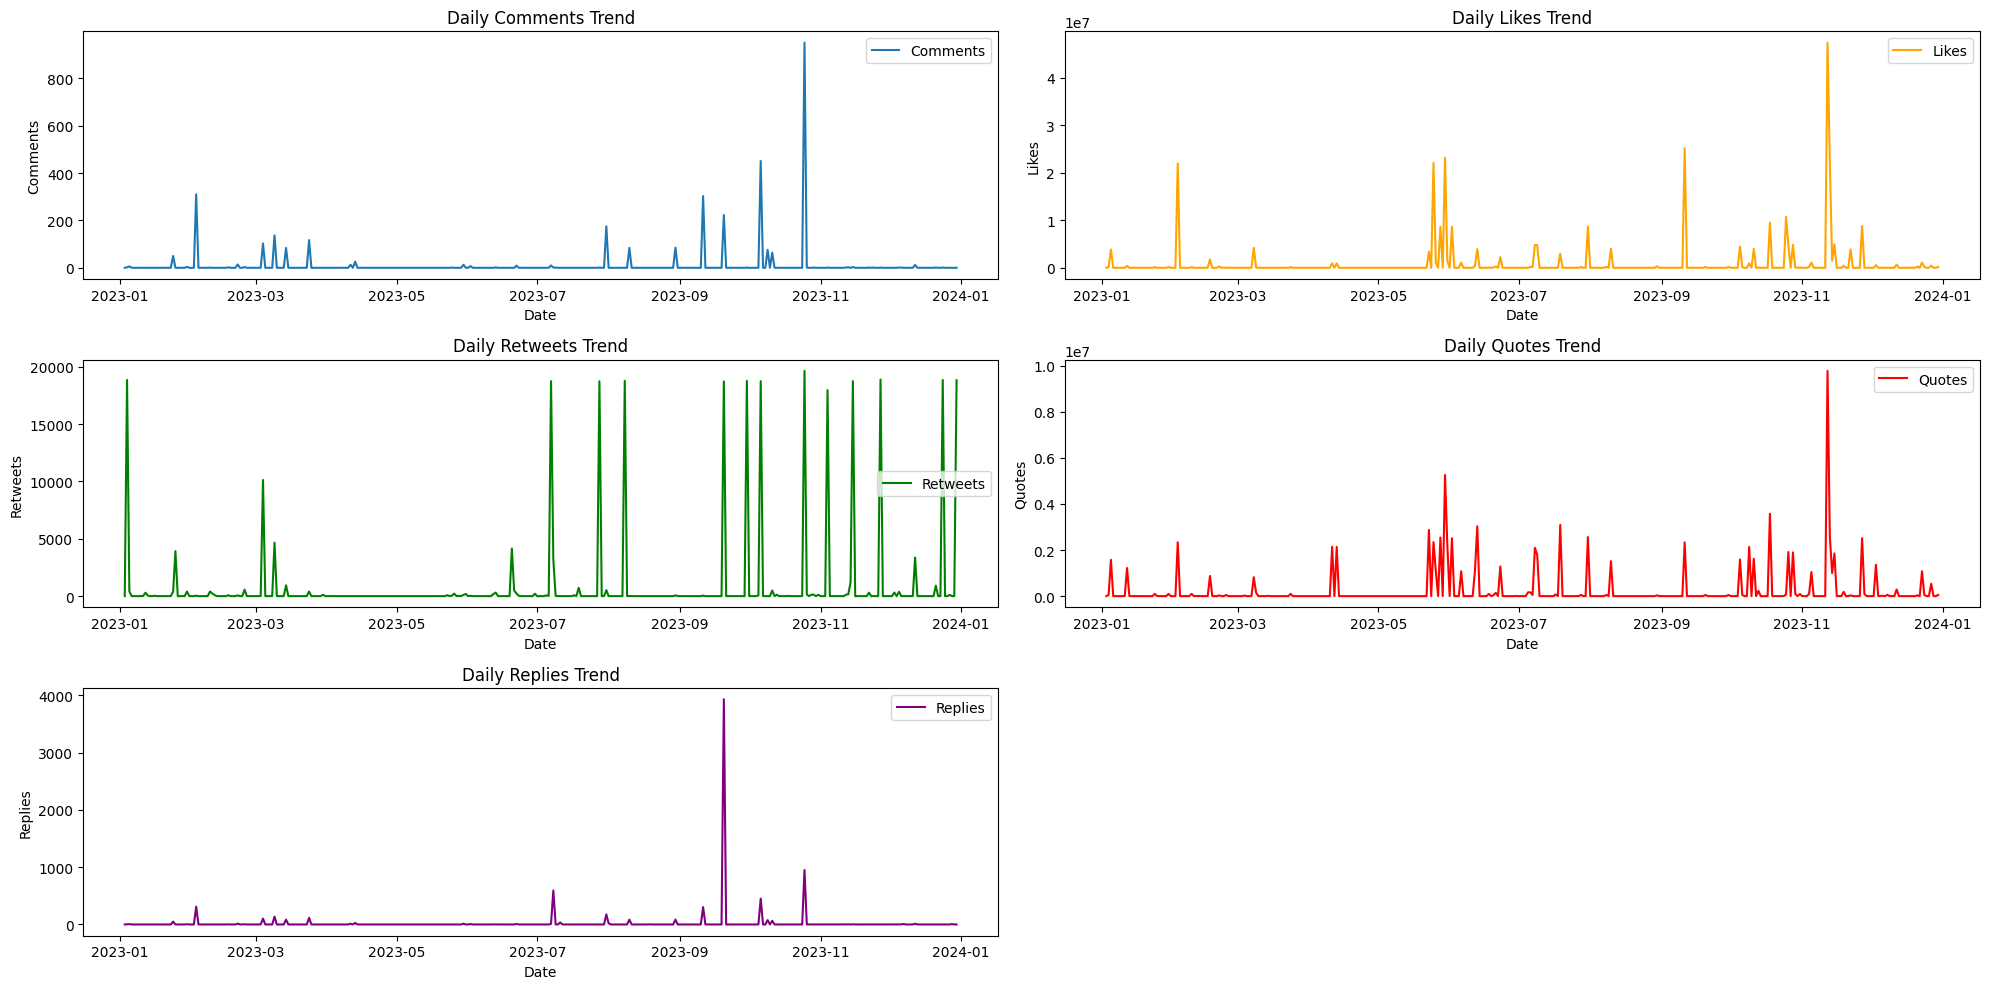

       commentcount         likes      retweets        quotes      replies
count    362.000000  3.620000e+02    362.000000  3.620000e+02   362.000000
mean       9.276243  8.201141e+05    791.563536  2.416942e+05    21.353591
std       62.792327  3.871370e+06   3547.991891  8.345025e+05   217.297916
min        0.000000  0.000000e+00      0.000000  0.000000e+00     0.000000
25%        0.000000  0.000000e+00      0.000000  0.000000e+00     0.000000
50%        0.000000  0.000000e+00      0.000000  0.000000e+00     0.000000
75%        0.000000  0.000000e+00      0.000000  0.000000e+00     0.000000
max      951.000000  4.737193e+07  19628.000000  9.774097e+06  3931.000000


In [10]:
# Plotting Tren Waktu
plt.figure(figsize=(20, 10))

plt.subplot(3, 2, 1)
plt.plot(toyota_daily.index, toyota_daily['commentcount'], label='Comments')
plt.title('Daily Comments Trend')
plt.xlabel('Date')
plt.ylabel('Comments')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(toyota_daily.index, toyota_daily['likes'], label='Likes', color='orange')
plt.title('Daily Likes Trend')
plt.xlabel('Date')
plt.ylabel('Likes')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(toyota_daily.index, toyota_daily['retweets'], label='Retweets', color='green')
plt.title('Daily Retweets Trend')
plt.xlabel('Date')
plt.ylabel('Retweets')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(toyota_daily.index, toyota_daily['quotes'], label='Quotes', color='red')
plt.title('Daily Quotes Trend')
plt.xlabel('Date')
plt.ylabel('Quotes')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(toyota_daily.index, toyota_daily['replies'], label='Replies', color='purple')
plt.title('Daily Replies Trend')
plt.xlabel('Date')
plt.ylabel('Replies')
plt.legend()

plt.tight_layout()
plt.show()

# Statistik Deskriptif
stats = toyota_daily.describe()
print(stats)

# **LSTM**

In [11]:
# Setting up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Define TrainingLogger
class TrainingLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logger.info(f'Epoch {epoch+1}: loss = {logs["loss"]:.4f}, val_loss = {logs["val_loss"]:.4f}')

In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30
X, y = create_sequences(scaled_df.values, SEQ_LENGTH)

In [13]:
# Split data into training and testing sets
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1507)

In [14]:
# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)
val_losses = []
metrics = {'mse': [], 'mae': [], 'rmse': []}

In [15]:
for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    print(f"Training fold {fold + 1}/{tscv.n_splits}")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = Sequential([
        LSTM(150, input_shape=(SEQ_LENGTH, len(numeric_columns)), return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(len(numeric_columns))
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=0,
                        callbacks=[TrainingLogger(),
                                   tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: tqdm.write(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - val_loss: {logs['val_loss']:.4f}"))])

    val_loss = history.history['val_loss']
    val_losses.append(val_loss)

    # Predict on validation set
    y_pred = model.predict(X_val)

    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    metrics['mse'].append(mse)
    metrics['mae'].append(mae)
    metrics['rmse'].append(rmse)

    print(f"Fold {fold + 1}: MSE = {mse:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# Save the model
model.save('lstm_toyota_model.h5')

Training fold 1/5
Epoch 1 - loss: 0.0067 - val_loss: 0.0034
Epoch 2 - loss: 0.0077 - val_loss: 0.0013
Epoch 3 - loss: 0.0033 - val_loss: 0.0009
Epoch 4 - loss: 0.0031 - val_loss: 0.0008
Epoch 5 - loss: 0.0029 - val_loss: 0.0009
Epoch 6 - loss: 0.0029 - val_loss: 0.0010
Epoch 7 - loss: 0.0028 - val_loss: 0.0009
Epoch 8 - loss: 0.0027 - val_loss: 0.0008
Epoch 9 - loss: 0.0027 - val_loss: 0.0008
Epoch 10 - loss: 0.0028 - val_loss: 0.0008
Epoch 11 - loss: 0.0028 - val_loss: 0.0008
Epoch 12 - loss: 0.0027 - val_loss: 0.0008
Epoch 13 - loss: 0.0027 - val_loss: 0.0010
Epoch 14 - loss: 0.0028 - val_loss: 0.0008
Epoch 15 - loss: 0.0027 - val_loss: 0.0008
Epoch 16 - loss: 0.0026 - val_loss: 0.0009
Epoch 17 - loss: 0.0026 - val_loss: 0.0008
Epoch 18 - loss: 0.0026 - val_loss: 0.0008
Epoch 19 - loss: 0.0026 - val_loss: 0.0010
Epoch 20 - loss: 0.0027 - val_loss: 0.0009
Epoch 21 - loss: 0.0026 - val_loss: 0.0007
Epoch 22 - loss: 0.0026 - val_loss: 0.0010
Epoch 23 - loss: 0.0027 - val_loss: 0.0010
Ep

2/2 [==============================] - 1s 29ms/step
Fold 5: MSE = 0.0223, MAE = 0.0400, RMSE = 0.1492


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


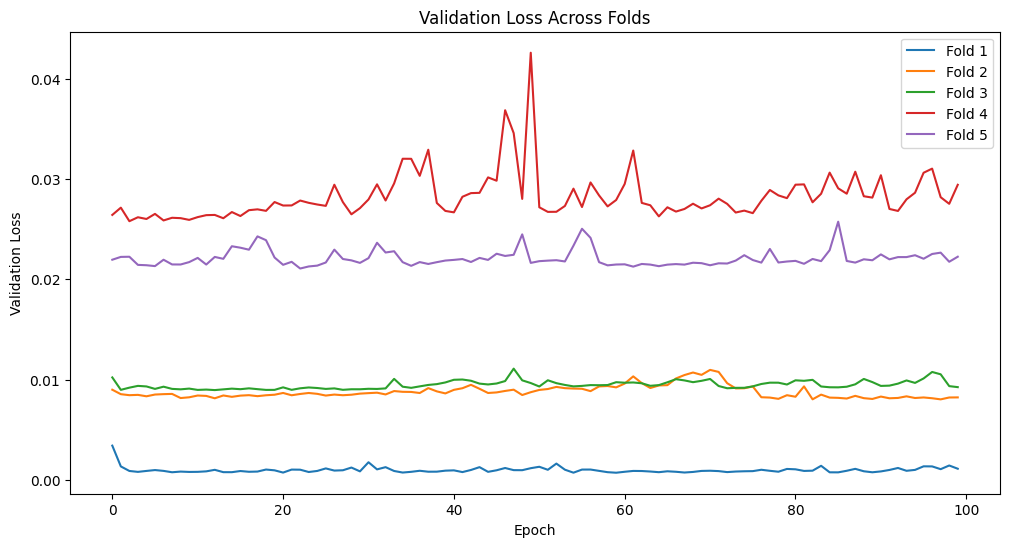

In [20]:
# Plot validation loss values from cross-validation
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_losses):
    plt.plot(val_loss, label=f'Fold {i+1}')
plt.title('Validation Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

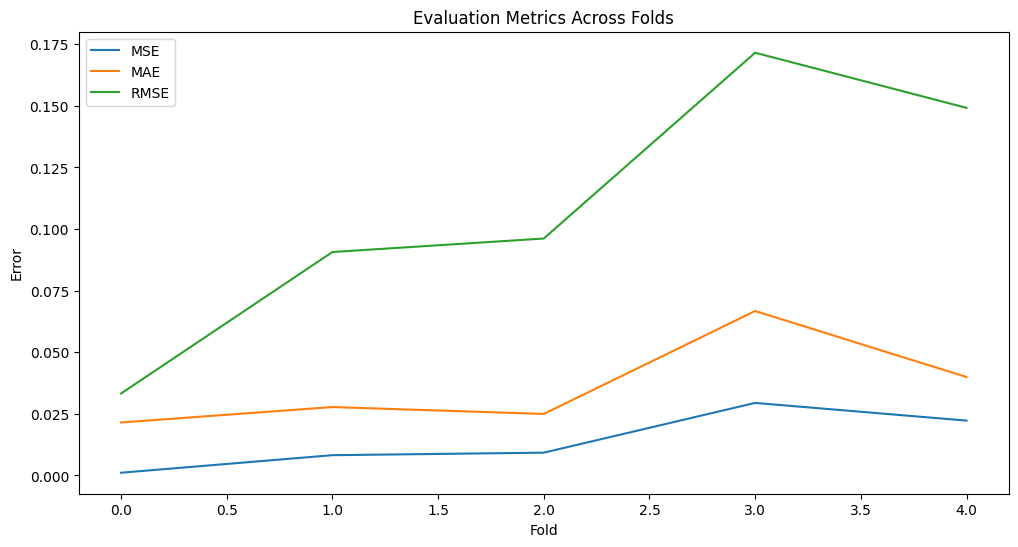

In [21]:
# Plot MSE, MAE, and RMSE for each fold
plt.figure(figsize=(12, 6))
plt.plot(metrics['mse'], label='MSE')
plt.plot(metrics['mae'], label='MAE')
plt.plot(metrics['rmse'], label='RMSE')
plt.title('Evaluation Metrics Across Folds')
plt.xlabel('Fold')
plt.ylabel('Error')
plt.legend()
plt.show()

# **Prediksi Tahun 2024**

In [22]:
# Memuat data asli untuk tahun 2024
data_2024 = data[(data['created_at'].dt.year == 2024) & (data['entity'] == 'Toyota')]
data_2024.set_index('created_at', inplace=True)
toyota_2024_daily = data_2024.resample('D').sum()
toyota_2024_daily.fillna(0, inplace=True)

# Normalisasi data tahun 2024 menggunakan scaler yang sama
scaled_data_2024 = scaler.transform(toyota_2024_daily[numeric_columns])

# Membuat sequence untuk prediksi
X_2024, y_2024 = create_sequences(scaled_data_2024, SEQ_LENGTH)

# Prediksi untuk tahun 2024
predictions_2024 = model.predict(X_2024)

# Inverse transform predictions
predictions_2024 = scaler.inverse_transform(predictions_2024)

# Konversi prediksi ke DataFrame
predictions_df = pd.DataFrame(predictions_2024, columns=numeric_columns, index=toyota_2024_daily.index[SEQ_LENGTH:])
predictions_df

4/4 [==============================] - 0s 26ms/step


,commentcount,likes,retweets,quotes,replies
created_at,,,,,
2024-01-31,-2.576195,4.111062e+05,214.538757,210509.531250,10.535028
2024-02-01,-0.851248,3.202198e+05,274.535980,186617.734375,10.709118
2024-02-02,0.511378,2.359676e+05,325.255798,167320.921875,5.057009
2024-02-03,-3.614100,1.028857e+06,-48.759121,400405.562500,-16.800426
2024-02-04,-3.675029,9.105511e+05,-177.974289,396188.812500,-36.330872
...,...,...,...,...,...
2024-05-20,-0.456534,4.277093e+05,319.125153,210835.562500,-9.042192
2024-05-21,-1.059749,5.079630e+05,278.553192,231758.640625,-8.387623
2024-05-22,-1.771551,5.457904e+05,238.089249,240750.890625,-5.084247


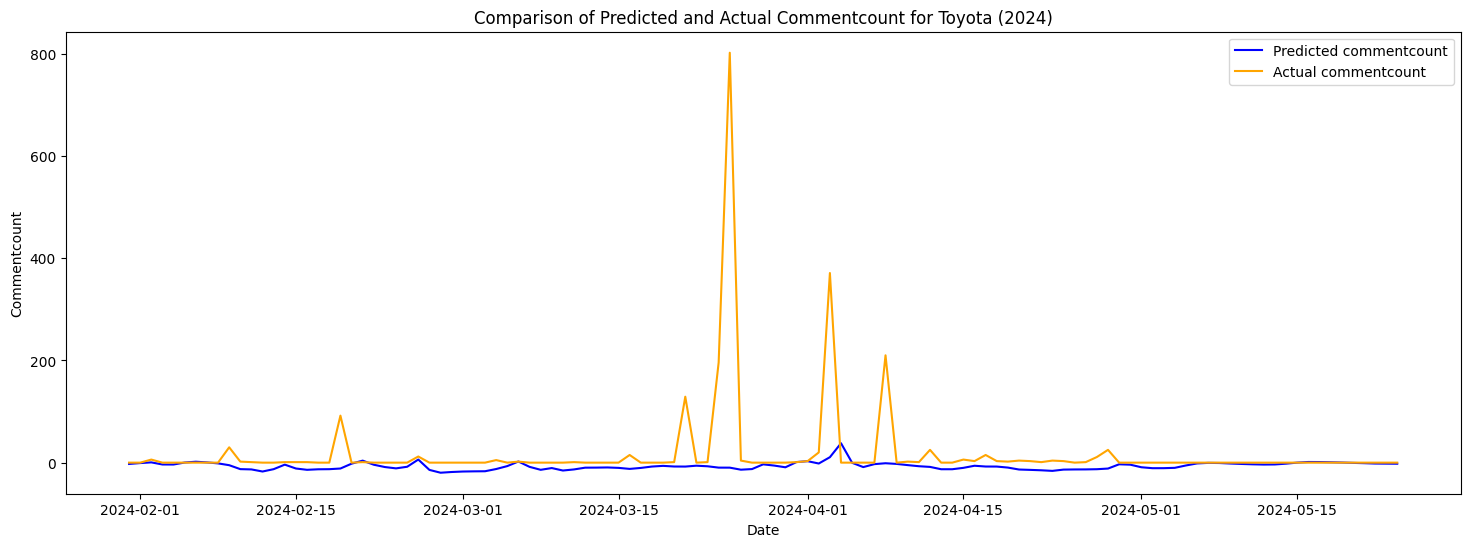

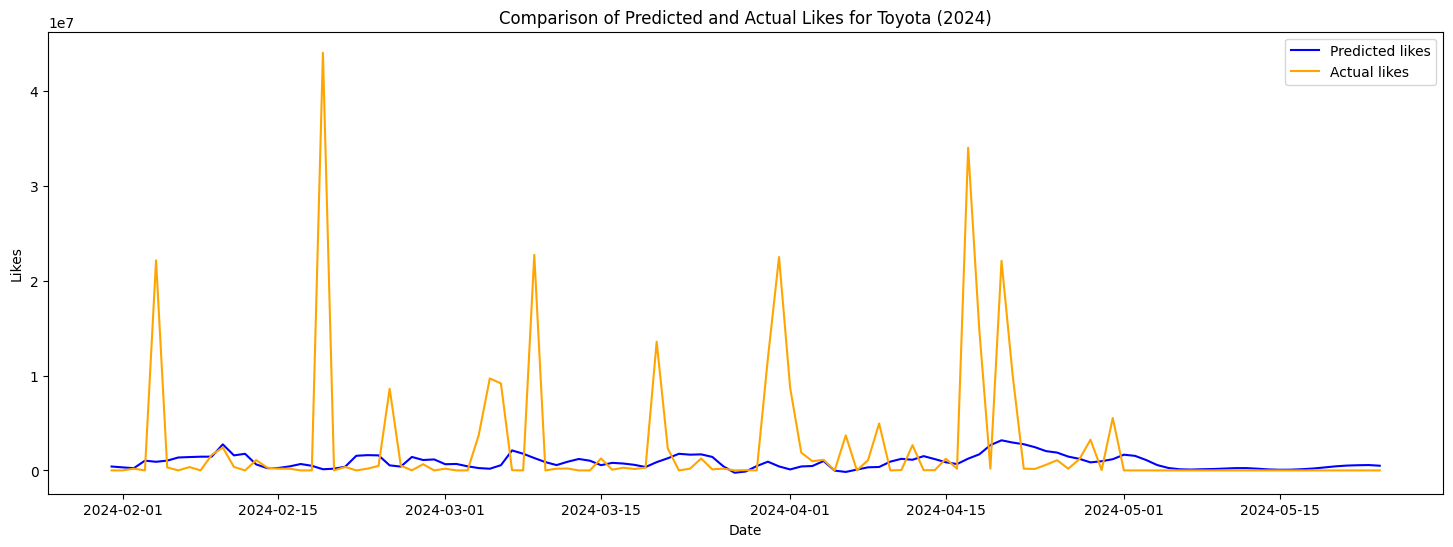

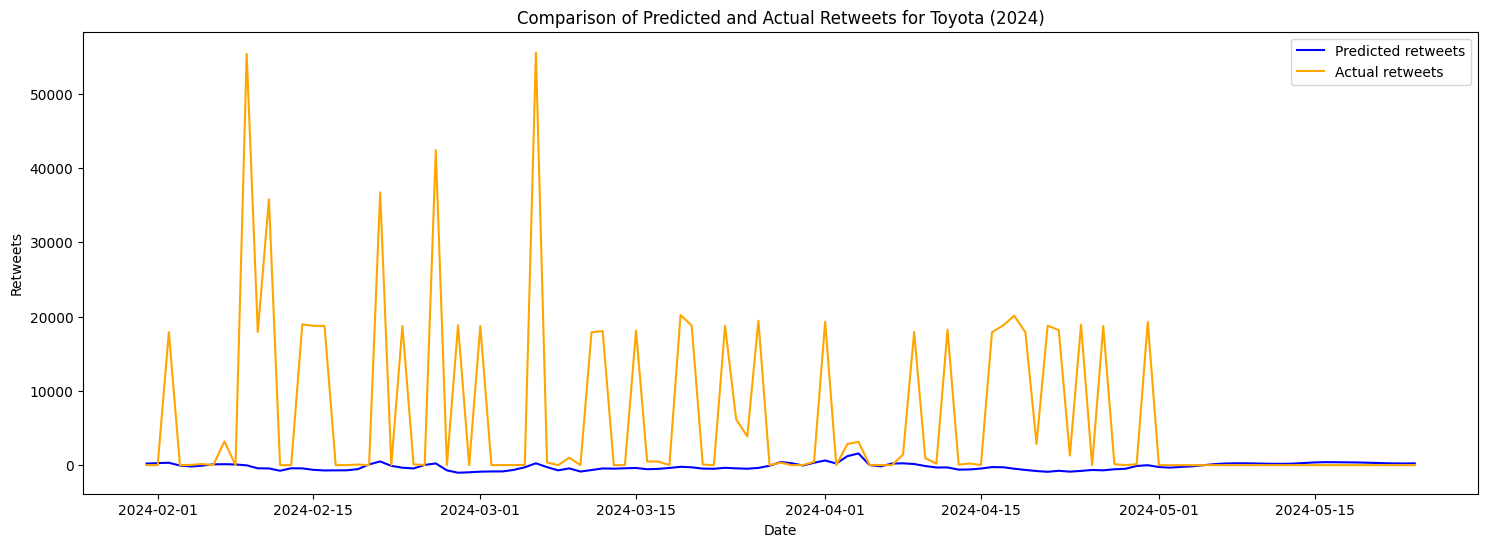

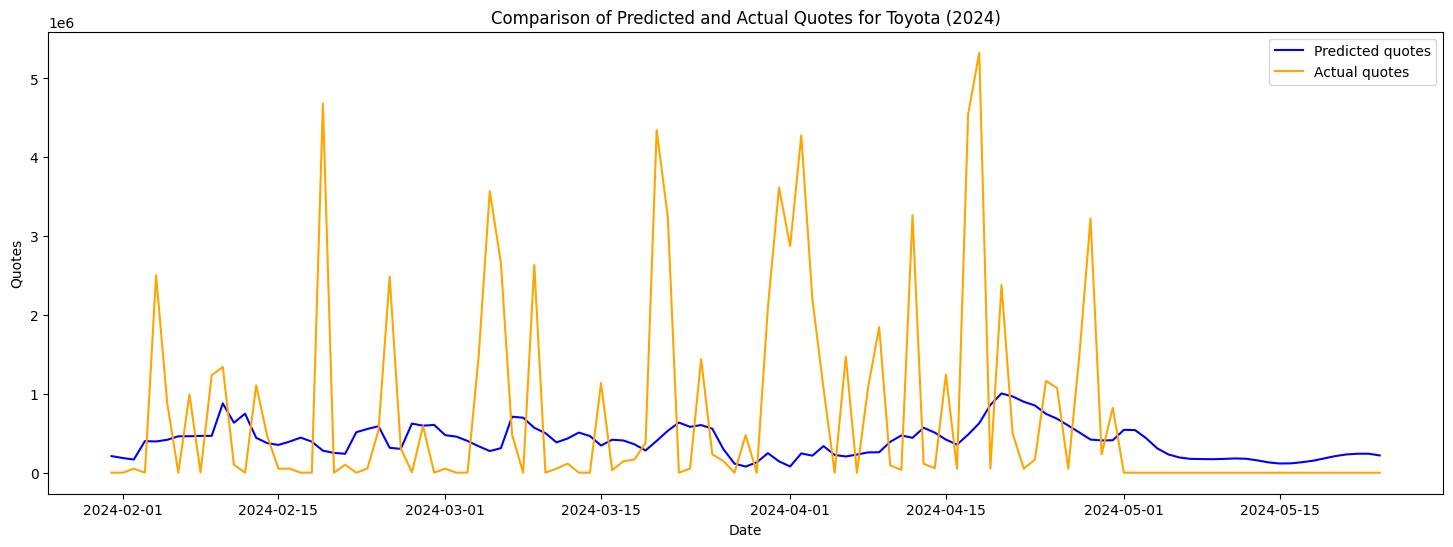

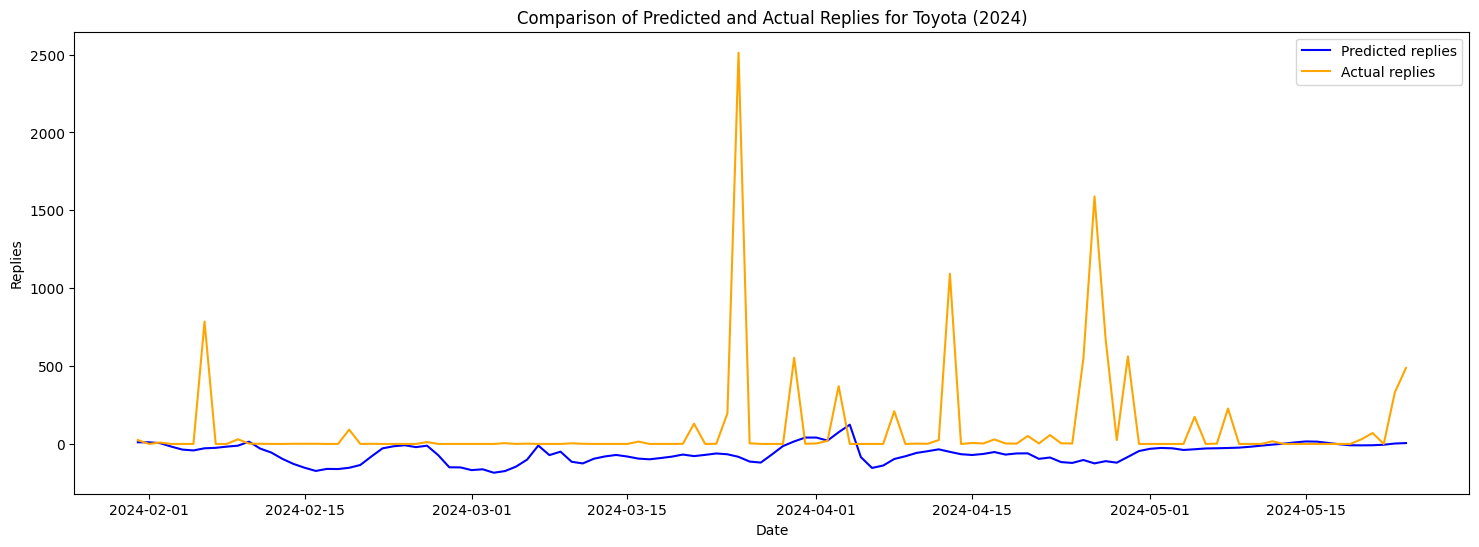

In [23]:
# Plot perbandingan prediksi dan data asli untuk semua variabel
for column in numeric_columns:
    plt.figure(figsize=(18, 6))
    plt.plot(predictions_df.index, predictions_df[column], label=f'Predicted {column}', color='blue')
    plt.plot(toyota_2024_daily.index[SEQ_LENGTH:], toyota_2024_daily[column][SEQ_LENGTH:], label=f'Actual {column}', color='orange')
    plt.title(f'Comparison of Predicted and Actual {column.capitalize()} for Toyota (2024)')
    plt.xlabel('Date')
    plt.ylabel(column.capitalize())
    plt.legend()
    plt.show()